<a href="https://colab.research.google.com/github/Shosh3sb/computer_vision_512/blob/main/Imag_colorization_BYTransfer_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
################################################

In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np

# Load the CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the input images to the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convert the input images to grayscale
x_train_gray = np.dot(x_train, [0.2989, 0.5870, 0.1140])
x_test_gray = np.dot(x_test, [0.2989, 0.5870, 0.1140])

# Reshape the input images to 32x32x1
x_train_gray = np.reshape(x_train_gray, (len(x_train_gray), 32, 32, 1))
x_test_gray = np.reshape(x_test_gray, (len(x_test_gray), 32, 32, 1))


2023-04-16 15:41:23.448872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
# Generator function
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

def make_discriminator_model():
    # Load the pre-trained VGG16 model
    vgg16 = VGG16(include_top=False, input_shape=(32, 32, 3))

    # Set all layers in the VGG16 model to non-trainable
    for layer in vgg16.layers:
        layer.trainable = False

    # Add a custom output layer to the VGG16 model
    model = tf.keras.Sequential()
    model.add(vgg16)
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# GAN function
def make_gan(generator, discriminator):
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Create the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Compile the discriminator model
discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

# Create the GAN model
gan = make_gan(generator, discriminator)

# Compile the GAN model
gan.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

# Train the GAN model
# ... add code here to prepare data and train the GAN ...


2023-04-16 15:41:26.056778: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-16 15:41:26.056929: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-16 15:41:26.056934: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 15:41:26.056944: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (firas-lab): /proc/driver/nvidia/version does not exist
2023-04-16 15:41:26.057062: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorF

In [ ]:
# Set the batch size and number of epochs
batch_size = 128
epochs = 200

# Create a function to generate noise vectors for the generator
def generate_noise(batch_size, noise_dim):
    return tf.random.normal([batch_size, noise_dim])

# Define the number of steps to take for each epoch
steps_per_epoch = x_train.shape[0] // batch_size

# Train the GAN model
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    if (epoch > 0 and epoch % 10 ==0):
        generator.save('local.h5')
        print("saved")
    # Shuffle the data
    np.random.shuffle(x_train)

    # Loop over batches of data
    for step in range(steps_per_epoch):
        # Sample a batch of real images
        real_images = x_train[step * batch_size:(step + 1) * batch_size]

        # Generate a batch of fake images
        noise = generate_noise(batch_size, 100)
        fake_images = generator.predict(noise)

        # Train the discriminator on real and fake images
        discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
        discriminator_loss = 0.5 * (discriminator_loss_real + discriminator_loss_fake)

        # Train the generator to fool the discriminator
        noise = generate_noise(batch_size, 100)
        generator_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print the losses for this step
        print(f"Step {step+1}/{steps_per_epoch} - D loss: {discriminator_loss:.4f}, G loss: {generator_loss:.4f}")


Epoch 1/200


2023-04-16 15:41:26.505728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-16 15:41:26.523403: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688000000 Hz


Step 1/390 - D loss: 0.7151, G loss: 0.2512
Step 2/390 - D loss: 0.7185, G loss: 0.1982
Step 3/390 - D loss: 0.7091, G loss: 0.1716
Step 4/390 - D loss: 0.7117, G loss: 0.1565
Step 5/390 - D loss: 0.7175, G loss: 0.1444
Step 6/390 - D loss: 0.7163, G loss: 0.1344
Step 7/390 - D loss: 0.7068, G loss: 0.1168
Step 8/390 - D loss: 0.7215, G loss: 0.1047
Step 9/390 - D loss: 0.7178, G loss: 0.0921
Step 10/390 - D loss: 0.7208, G loss: 0.0801
Step 11/390 - D loss: 0.7121, G loss: 0.0706
Step 12/390 - D loss: 0.7146, G loss: 0.0637
Step 13/390 - D loss: 0.7205, G loss: 0.0559
Step 14/390 - D loss: 0.7093, G loss: 0.0507
Step 15/390 - D loss: 0.7177, G loss: 0.0453
Step 16/390 - D loss: 0.7188, G loss: 0.0411
Step 17/390 - D loss: 0.7074, G loss: 0.0371
Step 18/390 - D loss: 0.7118, G loss: 0.0334
Step 19/390 - D loss: 0.7089, G loss: 0.0303
Step 20/390 - D loss: 0.6998, G loss: 0.0274
Step 21/390 - D loss: 0.7079, G loss: 0.0242
Step 22/390 - D loss: 0.7062, G loss: 0.0223
Step 23/390 - D los

Step 182/390 - D loss: 0.5227, G loss: 0.0010
Step 183/390 - D loss: 0.5255, G loss: 0.0010
Step 184/390 - D loss: 0.5175, G loss: 0.0010
Step 185/390 - D loss: 0.5265, G loss: 0.0010
Step 186/390 - D loss: 0.5160, G loss: 0.0010
Step 187/390 - D loss: 0.5345, G loss: 0.0010
Step 188/390 - D loss: 0.5238, G loss: 0.0010
Step 189/390 - D loss: 0.5283, G loss: 0.0010
Step 190/390 - D loss: 0.5326, G loss: 0.0011
Step 191/390 - D loss: 0.5319, G loss: 0.0011
Step 192/390 - D loss: 0.5228, G loss: 0.0011
Step 193/390 - D loss: 0.5383, G loss: 0.0011
Step 194/390 - D loss: 0.5347, G loss: 0.0011
Step 195/390 - D loss: 0.5442, G loss: 0.0011
Step 196/390 - D loss: 0.5428, G loss: 0.0012
Step 197/390 - D loss: 0.5424, G loss: 0.0011
Step 198/390 - D loss: 0.5252, G loss: 0.0012
Step 199/390 - D loss: 0.5341, G loss: 0.0011
Step 200/390 - D loss: 0.5353, G loss: 0.0012
Step 201/390 - D loss: 0.5249, G loss: 0.0013
Step 202/390 - D loss: 0.5317, G loss: 0.0013
Step 203/390 - D loss: 0.5490, G l

Step 361/390 - D loss: 1.6147, G loss: 0.0096
Step 362/390 - D loss: 1.5964, G loss: 0.0092
Step 363/390 - D loss: 1.6227, G loss: 0.0092
Step 364/390 - D loss: 1.6189, G loss: 0.0090
Step 365/390 - D loss: 1.6150, G loss: 0.0088
Step 366/390 - D loss: 1.6011, G loss: 0.0091
Step 367/390 - D loss: 1.5825, G loss: 0.0087
Step 368/390 - D loss: 1.5957, G loss: 0.0087
Step 369/390 - D loss: 1.6027, G loss: 0.0088
Step 370/390 - D loss: 1.6253, G loss: 0.0085
Step 371/390 - D loss: 1.6185, G loss: 0.0084
Step 372/390 - D loss: 1.6060, G loss: 0.0081
Step 373/390 - D loss: 1.6192, G loss: 0.0081
Step 374/390 - D loss: 1.5812, G loss: 0.0078
Step 375/390 - D loss: 1.5909, G loss: 0.0075
Step 376/390 - D loss: 1.6436, G loss: 0.0073
Step 377/390 - D loss: 1.6386, G loss: 0.0071
Step 378/390 - D loss: 1.6598, G loss: 0.0069
Step 379/390 - D loss: 1.6321, G loss: 0.0065
Step 380/390 - D loss: 1.6567, G loss: 0.0064
Step 381/390 - D loss: 1.6223, G loss: 0.0061
Step 382/390 - D loss: 1.6556, G l

Step 152/390 - D loss: 2.5860, G loss: 0.0060
Step 153/390 - D loss: 2.6287, G loss: 0.0061
Step 154/390 - D loss: 2.6452, G loss: 0.0060
Step 155/390 - D loss: 2.6190, G loss: 0.0061
Step 156/390 - D loss: 2.6455, G loss: 0.0059
Step 157/390 - D loss: 2.6857, G loss: 0.0056
Step 158/390 - D loss: 2.6386, G loss: 0.0058
Step 159/390 - D loss: 2.6687, G loss: 0.0058
Step 160/390 - D loss: 2.6611, G loss: 0.0056
Step 161/390 - D loss: 2.6682, G loss: 0.0057
Step 162/390 - D loss: 2.6687, G loss: 0.0055
Step 163/390 - D loss: 2.6321, G loss: 0.0057
Step 164/390 - D loss: 2.6491, G loss: 0.0056
Step 165/390 - D loss: 2.6849, G loss: 0.0055
Step 166/390 - D loss: 2.6768, G loss: 0.0053
Step 167/390 - D loss: 2.6758, G loss: 0.0052
Step 168/390 - D loss: 2.6887, G loss: 0.0053
Step 169/390 - D loss: 2.6902, G loss: 0.0052
Step 170/390 - D loss: 2.7106, G loss: 0.0052
Step 171/390 - D loss: 2.6990, G loss: 0.0051
Step 172/390 - D loss: 2.6997, G loss: 0.0050
Step 173/390 - D loss: 2.7040, G l

Step 331/390 - D loss: 2.7155, G loss: 0.0055
Step 332/390 - D loss: 2.7185, G loss: 0.0055
Step 333/390 - D loss: 2.6902, G loss: 0.0055
Step 334/390 - D loss: 2.7102, G loss: 0.0054
Step 335/390 - D loss: 2.6997, G loss: 0.0055
Step 336/390 - D loss: 2.7074, G loss: 0.0056
Step 337/390 - D loss: 2.7156, G loss: 0.0054
Step 338/390 - D loss: 2.7071, G loss: 0.0056
Step 339/390 - D loss: 2.7017, G loss: 0.0056
Step 340/390 - D loss: 2.7042, G loss: 0.0056
Step 341/390 - D loss: 2.7124, G loss: 0.0055
Step 342/390 - D loss: 2.6982, G loss: 0.0056
Step 343/390 - D loss: 2.7002, G loss: 0.0057
Step 344/390 - D loss: 2.7009, G loss: 0.0056
Step 345/390 - D loss: 2.6865, G loss: 0.0057
Step 346/390 - D loss: 2.6934, G loss: 0.0056
Step 347/390 - D loss: 2.6949, G loss: 0.0056
Step 348/390 - D loss: 2.6849, G loss: 0.0057
Step 349/390 - D loss: 2.6961, G loss: 0.0056
Step 350/390 - D loss: 2.6980, G loss: 0.0056
Step 351/390 - D loss: 2.6932, G loss: 0.0056
Step 352/390 - D loss: 2.6890, G l

Step 122/390 - D loss: 3.2795, G loss: 0.0018
Step 123/390 - D loss: 3.2391, G loss: 0.0018
Step 124/390 - D loss: 3.2775, G loss: 0.0018
Step 125/390 - D loss: 3.2740, G loss: 0.0018
Step 126/390 - D loss: 3.2531, G loss: 0.0019
Step 127/390 - D loss: 3.2525, G loss: 0.0018
Step 128/390 - D loss: 3.2475, G loss: 0.0018
Step 129/390 - D loss: 3.2833, G loss: 0.0019
Step 130/390 - D loss: 3.2657, G loss: 0.0018
Step 131/390 - D loss: 3.2656, G loss: 0.0019
Step 132/390 - D loss: 3.2726, G loss: 0.0018
Step 133/390 - D loss: 3.2838, G loss: 0.0018
Step 134/390 - D loss: 3.2777, G loss: 0.0018
Step 135/390 - D loss: 3.2800, G loss: 0.0018
Step 136/390 - D loss: 3.2887, G loss: 0.0019
Step 137/390 - D loss: 3.2775, G loss: 0.0018
Step 138/390 - D loss: 3.2682, G loss: 0.0019
Step 139/390 - D loss: 3.2725, G loss: 0.0018
Step 140/390 - D loss: 3.2783, G loss: 0.0019
Step 141/390 - D loss: 3.3178, G loss: 0.0019
Step 142/390 - D loss: 3.2935, G loss: 0.0018
Step 143/390 - D loss: 3.2957, G l

Step 301/390 - D loss: 3.4052, G loss: 0.0018
Step 302/390 - D loss: 3.3955, G loss: 0.0018
Step 303/390 - D loss: 3.3832, G loss: 0.0018
Step 304/390 - D loss: 3.4170, G loss: 0.0018
Step 305/390 - D loss: 3.4131, G loss: 0.0018
Step 306/390 - D loss: 3.4136, G loss: 0.0018
Step 307/390 - D loss: 3.3746, G loss: 0.0018
Step 308/390 - D loss: 3.3898, G loss: 0.0018
Step 309/390 - D loss: 3.3919, G loss: 0.0018
Step 310/390 - D loss: 3.3797, G loss: 0.0019
Step 311/390 - D loss: 3.3996, G loss: 0.0018
Step 312/390 - D loss: 3.3841, G loss: 0.0018
Step 313/390 - D loss: 3.3886, G loss: 0.0019
Step 314/390 - D loss: 3.3908, G loss: 0.0019
Step 315/390 - D loss: 3.4148, G loss: 0.0019
Step 316/390 - D loss: 3.3902, G loss: 0.0018
Step 317/390 - D loss: 3.3924, G loss: 0.0019
Step 318/390 - D loss: 3.3736, G loss: 0.0019
Step 319/390 - D loss: 3.3673, G loss: 0.0019
Step 320/390 - D loss: 3.3759, G loss: 0.0019
Step 321/390 - D loss: 3.3861, G loss: 0.0019
Step 322/390 - D loss: 3.3704, G l

Step 91/390 - D loss: 3.3318, G loss: 0.0021
Step 92/390 - D loss: 3.3539, G loss: 0.0021
Step 93/390 - D loss: 3.3410, G loss: 0.0020
Step 94/390 - D loss: 3.3515, G loss: 0.0020
Step 95/390 - D loss: 3.3779, G loss: 0.0020
Step 96/390 - D loss: 3.3767, G loss: 0.0020
Step 97/390 - D loss: 3.3612, G loss: 0.0019
Step 98/390 - D loss: 3.3841, G loss: 0.0019
Step 99/390 - D loss: 3.3752, G loss: 0.0019
Step 100/390 - D loss: 3.3820, G loss: 0.0019
Step 101/390 - D loss: 3.4140, G loss: 0.0019
Step 102/390 - D loss: 3.4133, G loss: 0.0019
Step 103/390 - D loss: 3.4017, G loss: 0.0019
Step 104/390 - D loss: 3.3749, G loss: 0.0018
Step 105/390 - D loss: 3.4532, G loss: 0.0019
Step 106/390 - D loss: 3.3935, G loss: 0.0019
Step 107/390 - D loss: 3.4072, G loss: 0.0019
Step 108/390 - D loss: 3.4209, G loss: 0.0018
Step 109/390 - D loss: 3.4291, G loss: 0.0018
Step 110/390 - D loss: 3.4177, G loss: 0.0018
Step 111/390 - D loss: 3.3961, G loss: 0.0018
Step 112/390 - D loss: 3.4374, G loss: 0.00

Step 270/390 - D loss: 3.3344, G loss: 0.0020
Step 271/390 - D loss: 3.3432, G loss: 0.0021
Step 272/390 - D loss: 3.3462, G loss: 0.0021
Step 273/390 - D loss: 3.3719, G loss: 0.0021
Step 274/390 - D loss: 3.3514, G loss: 0.0021
Step 275/390 - D loss: 3.3303, G loss: 0.0021
Step 276/390 - D loss: 3.3641, G loss: 0.0021
Step 277/390 - D loss: 3.3456, G loss: 0.0021
Step 278/390 - D loss: 3.3555, G loss: 0.0021
Step 279/390 - D loss: 3.3371, G loss: 0.0021
Step 280/390 - D loss: 3.3130, G loss: 0.0021
Step 281/390 - D loss: 3.3607, G loss: 0.0021
Step 282/390 - D loss: 3.3220, G loss: 0.0021
Step 283/390 - D loss: 3.3382, G loss: 0.0021
Step 284/390 - D loss: 3.3224, G loss: 0.0021
Step 285/390 - D loss: 3.3517, G loss: 0.0021
Step 286/390 - D loss: 3.3266, G loss: 0.0021
Step 287/390 - D loss: 3.3245, G loss: 0.0021
Step 288/390 - D loss: 3.3372, G loss: 0.0021
Step 289/390 - D loss: 3.3092, G loss: 0.0021
Step 290/390 - D loss: 3.3384, G loss: 0.0021
Step 291/390 - D loss: 3.3197, G l

Step 60/390 - D loss: 3.2432, G loss: 0.0024
Step 61/390 - D loss: 3.2410, G loss: 0.0025
Step 62/390 - D loss: 3.2173, G loss: 0.0025
Step 63/390 - D loss: 3.2215, G loss: 0.0024
Step 64/390 - D loss: 3.2269, G loss: 0.0025
Step 65/390 - D loss: 3.2245, G loss: 0.0025
Step 66/390 - D loss: 3.2219, G loss: 0.0025
Step 67/390 - D loss: 3.2471, G loss: 0.0025
Step 68/390 - D loss: 3.2298, G loss: 0.0024
Step 69/390 - D loss: 3.2310, G loss: 0.0025
Step 70/390 - D loss: 3.2219, G loss: 0.0025
Step 71/390 - D loss: 3.2210, G loss: 0.0025
Step 72/390 - D loss: 3.2322, G loss: 0.0025
Step 73/390 - D loss: 3.2191, G loss: 0.0025
Step 74/390 - D loss: 3.2290, G loss: 0.0025
Step 75/390 - D loss: 3.2119, G loss: 0.0025
Step 76/390 - D loss: 3.2317, G loss: 0.0025
Step 77/390 - D loss: 3.2146, G loss: 0.0025
Step 78/390 - D loss: 3.2315, G loss: 0.0025
Step 79/390 - D loss: 3.2320, G loss: 0.0025
Step 80/390 - D loss: 3.2126, G loss: 0.0025
Step 81/390 - D loss: 3.1892, G loss: 0.0025
Step 82/39

Step 239/390 - D loss: 3.1704, G loss: 0.0027
Step 240/390 - D loss: 3.1660, G loss: 0.0027
Step 241/390 - D loss: 3.1600, G loss: 0.0027
Step 242/390 - D loss: 3.1674, G loss: 0.0027
Step 243/390 - D loss: 3.1463, G loss: 0.0027
Step 244/390 - D loss: 3.1652, G loss: 0.0027
Step 245/390 - D loss: 3.1720, G loss: 0.0027
Step 246/390 - D loss: 3.1640, G loss: 0.0027
Step 247/390 - D loss: 3.1571, G loss: 0.0027
Step 248/390 - D loss: 3.1579, G loss: 0.0027
Step 249/390 - D loss: 3.1565, G loss: 0.0027
Step 250/390 - D loss: 3.1476, G loss: 0.0027
Step 251/390 - D loss: 3.1678, G loss: 0.0027
Step 252/390 - D loss: 3.1567, G loss: 0.0027
Step 253/390 - D loss: 3.1814, G loss: 0.0027
Step 254/390 - D loss: 3.1465, G loss: 0.0027
Step 255/390 - D loss: 3.1554, G loss: 0.0027
Step 256/390 - D loss: 3.1630, G loss: 0.0027
Step 257/390 - D loss: 3.1643, G loss: 0.0027
Step 258/390 - D loss: 3.1537, G loss: 0.0027
Step 259/390 - D loss: 3.1639, G loss: 0.0027
Step 260/390 - D loss: 3.1544, G l

Step 28/390 - D loss: 3.0822, G loss: 0.0030
Step 29/390 - D loss: 3.0700, G loss: 0.0030
Step 30/390 - D loss: 3.0845, G loss: 0.0030
Step 31/390 - D loss: 3.0846, G loss: 0.0030
Step 32/390 - D loss: 3.0783, G loss: 0.0030
Step 33/390 - D loss: 3.0945, G loss: 0.0030
Step 34/390 - D loss: 3.0837, G loss: 0.0030
Step 35/390 - D loss: 3.0986, G loss: 0.0030
Step 36/390 - D loss: 3.0915, G loss: 0.0030
Step 37/390 - D loss: 3.0745, G loss: 0.0030
Step 38/390 - D loss: 3.0786, G loss: 0.0030
Step 39/390 - D loss: 3.0584, G loss: 0.0030
Step 40/390 - D loss: 3.0851, G loss: 0.0030
Step 41/390 - D loss: 3.0986, G loss: 0.0030
Step 42/390 - D loss: 3.0844, G loss: 0.0030
Step 43/390 - D loss: 3.0832, G loss: 0.0030
Step 44/390 - D loss: 3.0756, G loss: 0.0030
Step 45/390 - D loss: 3.0857, G loss: 0.0030
Step 46/390 - D loss: 3.0807, G loss: 0.0030
Step 47/390 - D loss: 3.0667, G loss: 0.0030
Step 48/390 - D loss: 3.0964, G loss: 0.0030
Step 49/390 - D loss: 3.0911, G loss: 0.0030
Step 50/39

Step 208/390 - D loss: 3.0600, G loss: 0.0030
Step 209/390 - D loss: 3.0569, G loss: 0.0030
Step 210/390 - D loss: 3.0745, G loss: 0.0030
Step 211/390 - D loss: 3.0608, G loss: 0.0030
Step 212/390 - D loss: 3.0638, G loss: 0.0030
Step 213/390 - D loss: 3.0517, G loss: 0.0030
Step 214/390 - D loss: 3.0527, G loss: 0.0030
Step 215/390 - D loss: 3.0709, G loss: 0.0030
Step 216/390 - D loss: 3.0486, G loss: 0.0030
Step 217/390 - D loss: 3.0527, G loss: 0.0030
Step 218/390 - D loss: 3.0462, G loss: 0.0031
Step 219/390 - D loss: 3.0478, G loss: 0.0031
Step 220/390 - D loss: 3.0453, G loss: 0.0030
Step 221/390 - D loss: 3.0605, G loss: 0.0030
Step 222/390 - D loss: 3.0755, G loss: 0.0030
Step 223/390 - D loss: 3.0795, G loss: 0.0030
Step 224/390 - D loss: 3.0632, G loss: 0.0029
Step 225/390 - D loss: 3.0808, G loss: 0.0029
Step 226/390 - D loss: 3.0840, G loss: 0.0029
Step 227/390 - D loss: 3.1010, G loss: 0.0028
Step 228/390 - D loss: 3.0978, G loss: 0.0027
Step 229/390 - D loss: 3.1058, G l

Step 387/390 - D loss: 4.4397, G loss: 0.0002
Step 388/390 - D loss: 4.4356, G loss: 0.0002
Step 389/390 - D loss: 4.4163, G loss: 0.0002
Step 390/390 - D loss: 4.4373, G loss: 0.0002
Epoch 7/200
Step 1/390 - D loss: 4.4098, G loss: 0.0002
Step 2/390 - D loss: 4.4241, G loss: 0.0002
Step 3/390 - D loss: 4.3988, G loss: 0.0002
Step 4/390 - D loss: 4.4028, G loss: 0.0002
Step 5/390 - D loss: 4.3980, G loss: 0.0002
Step 6/390 - D loss: 4.3931, G loss: 0.0002
Step 7/390 - D loss: 4.3962, G loss: 0.0002
Step 8/390 - D loss: 4.3729, G loss: 0.0002
Step 9/390 - D loss: 4.3631, G loss: 0.0002
Step 10/390 - D loss: 4.3697, G loss: 0.0002
Step 11/390 - D loss: 4.3644, G loss: 0.0003
Step 12/390 - D loss: 4.3849, G loss: 0.0003
Step 13/390 - D loss: 4.3484, G loss: 0.0003
Step 14/390 - D loss: 4.3671, G loss: 0.0003
Step 15/390 - D loss: 4.3544, G loss: 0.0003
Step 16/390 - D loss: 4.3532, G loss: 0.0003
Step 17/390 - D loss: 4.3523, G loss: 0.0003
Step 18/390 - D loss: 4.3560, G loss: 0.0003
Ste

Step 178/390 - D loss: 4.4410, G loss: 0.0002
Step 179/390 - D loss: 4.4366, G loss: 0.0002
Step 180/390 - D loss: 4.4349, G loss: 0.0002
Step 181/390 - D loss: 4.4206, G loss: 0.0002
Step 182/390 - D loss: 4.4476, G loss: 0.0002
Step 183/390 - D loss: 4.4279, G loss: 0.0002
Step 184/390 - D loss: 4.4462, G loss: 0.0002
Step 185/390 - D loss: 4.4308, G loss: 0.0002
Step 186/390 - D loss: 4.4679, G loss: 0.0002
Step 187/390 - D loss: 4.4227, G loss: 0.0002
Step 188/390 - D loss: 4.4082, G loss: 0.0002
Step 189/390 - D loss: 4.4300, G loss: 0.0002
Step 190/390 - D loss: 4.4381, G loss: 0.0002
Step 191/390 - D loss: 4.4140, G loss: 0.0002
Step 192/390 - D loss: 4.4111, G loss: 0.0002
Step 193/390 - D loss: 4.4027, G loss: 0.0002
Step 194/390 - D loss: 4.4077, G loss: 0.0002
Step 195/390 - D loss: 4.4152, G loss: 0.0002
Step 196/390 - D loss: 4.4148, G loss: 0.0003
Step 197/390 - D loss: 4.4174, G loss: 0.0003
Step 198/390 - D loss: 4.4125, G loss: 0.0003
Step 199/390 - D loss: 4.4015, G l

Step 357/390 - D loss: 4.1463, G loss: 0.0004
Step 358/390 - D loss: 4.1650, G loss: 0.0004
Step 359/390 - D loss: 4.1527, G loss: 0.0004
Step 360/390 - D loss: 4.1659, G loss: 0.0004
Step 361/390 - D loss: 4.1626, G loss: 0.0004
Step 362/390 - D loss: 4.1726, G loss: 0.0004
Step 363/390 - D loss: 4.1501, G loss: 0.0004
Step 364/390 - D loss: 4.1641, G loss: 0.0004
Step 365/390 - D loss: 4.1491, G loss: 0.0004
Step 366/390 - D loss: 4.1417, G loss: 0.0004
Step 367/390 - D loss: 4.1600, G loss: 0.0004
Step 368/390 - D loss: 4.1497, G loss: 0.0004
Step 369/390 - D loss: 4.1454, G loss: 0.0004
Step 370/390 - D loss: 4.1330, G loss: 0.0004
Step 371/390 - D loss: 4.1224, G loss: 0.0004
Step 372/390 - D loss: 4.1548, G loss: 0.0004
Step 373/390 - D loss: 4.1436, G loss: 0.0004
Step 374/390 - D loss: 4.1417, G loss: 0.0004
Step 375/390 - D loss: 4.1240, G loss: 0.0004
Step 376/390 - D loss: 4.1262, G loss: 0.0004
Step 377/390 - D loss: 4.1383, G loss: 0.0004
Step 378/390 - D loss: 4.1446, G l

Step 148/390 - D loss: 4.0223, G loss: 0.0005
Step 149/390 - D loss: 4.0233, G loss: 0.0005
Step 150/390 - D loss: 4.0373, G loss: 0.0005
Step 151/390 - D loss: 4.0227, G loss: 0.0005
Step 152/390 - D loss: 4.0164, G loss: 0.0005
Step 153/390 - D loss: 4.0173, G loss: 0.0005
Step 154/390 - D loss: 4.0451, G loss: 0.0005
Step 155/390 - D loss: 4.0333, G loss: 0.0005
Step 156/390 - D loss: 4.0262, G loss: 0.0005
Step 157/390 - D loss: 4.0242, G loss: 0.0005
Step 158/390 - D loss: 4.0362, G loss: 0.0005
Step 159/390 - D loss: 4.0446, G loss: 0.0005
Step 160/390 - D loss: 4.0403, G loss: 0.0005
Step 161/390 - D loss: 4.0119, G loss: 0.0005
Step 162/390 - D loss: 4.0412, G loss: 0.0005
Step 163/390 - D loss: 4.0332, G loss: 0.0005
Step 164/390 - D loss: 4.0217, G loss: 0.0005
Step 165/390 - D loss: 4.0096, G loss: 0.0005
Step 166/390 - D loss: 4.0290, G loss: 0.0005
Step 167/390 - D loss: 4.0150, G loss: 0.0005
Step 168/390 - D loss: 4.0049, G loss: 0.0005
Step 169/390 - D loss: 4.0144, G l

Step 327/390 - D loss: 3.8892, G loss: 0.0006
Step 328/390 - D loss: 3.8938, G loss: 0.0006
Step 329/390 - D loss: 3.8792, G loss: 0.0006
Step 330/390 - D loss: 3.8828, G loss: 0.0006
Step 331/390 - D loss: 3.8593, G loss: 0.0006
Step 332/390 - D loss: 3.8633, G loss: 0.0006
Step 333/390 - D loss: 3.8568, G loss: 0.0006
Step 334/390 - D loss: 3.8675, G loss: 0.0006
Step 335/390 - D loss: 3.8703, G loss: 0.0006
Step 336/390 - D loss: 3.8808, G loss: 0.0007
Step 337/390 - D loss: 3.8630, G loss: 0.0007
Step 338/390 - D loss: 3.8674, G loss: 0.0007
Step 339/390 - D loss: 3.8502, G loss: 0.0007
Step 340/390 - D loss: 3.8666, G loss: 0.0007
Step 341/390 - D loss: 3.8672, G loss: 0.0007
Step 342/390 - D loss: 3.8803, G loss: 0.0007
Step 343/390 - D loss: 3.8587, G loss: 0.0007
Step 344/390 - D loss: 3.8855, G loss: 0.0007
Step 345/390 - D loss: 3.8688, G loss: 0.0007
Step 346/390 - D loss: 3.8758, G loss: 0.0007
Step 347/390 - D loss: 3.8757, G loss: 0.0007
Step 348/390 - D loss: 3.8691, G l

Step 118/390 - D loss: 4.2463, G loss: 0.0003
Step 119/390 - D loss: 4.2272, G loss: 0.0003
Step 120/390 - D loss: 4.2436, G loss: 0.0003
Step 121/390 - D loss: 4.2156, G loss: 0.0003
Step 122/390 - D loss: 4.1951, G loss: 0.0003
Step 123/390 - D loss: 4.1931, G loss: 0.0003
Step 124/390 - D loss: 4.2006, G loss: 0.0003
Step 125/390 - D loss: 4.2062, G loss: 0.0003
Step 126/390 - D loss: 4.2016, G loss: 0.0003
Step 127/390 - D loss: 4.1945, G loss: 0.0003
Step 128/390 - D loss: 4.2049, G loss: 0.0003
Step 129/390 - D loss: 4.1913, G loss: 0.0003
Step 130/390 - D loss: 4.1804, G loss: 0.0003
Step 131/390 - D loss: 4.1674, G loss: 0.0003
Step 132/390 - D loss: 4.1653, G loss: 0.0003
Step 133/390 - D loss: 4.1658, G loss: 0.0003
Step 134/390 - D loss: 4.1564, G loss: 0.0003
Step 135/390 - D loss: 4.1574, G loss: 0.0003
Step 136/390 - D loss: 4.1744, G loss: 0.0003
Step 137/390 - D loss: 4.1682, G loss: 0.0003
Step 138/390 - D loss: 4.1576, G loss: 0.0003
Step 139/390 - D loss: 4.1573, G l

Step 297/390 - D loss: 3.8590, G loss: 0.0006
Step 298/390 - D loss: 3.8504, G loss: 0.0006
Step 299/390 - D loss: 3.8699, G loss: 0.0006
Step 300/390 - D loss: 3.8402, G loss: 0.0006
Step 301/390 - D loss: 3.8495, G loss: 0.0006
Step 302/390 - D loss: 3.8631, G loss: 0.0006
Step 303/390 - D loss: 3.8566, G loss: 0.0006
Step 304/390 - D loss: 3.8549, G loss: 0.0006
Step 305/390 - D loss: 3.8712, G loss: 0.0006
Step 306/390 - D loss: 3.8601, G loss: 0.0006
Step 307/390 - D loss: 3.8614, G loss: 0.0006
Step 308/390 - D loss: 3.8425, G loss: 0.0006
Step 309/390 - D loss: 3.8483, G loss: 0.0006
Step 310/390 - D loss: 3.8459, G loss: 0.0006
Step 311/390 - D loss: 3.8382, G loss: 0.0006
Step 312/390 - D loss: 3.8587, G loss: 0.0006
Step 313/390 - D loss: 3.8593, G loss: 0.0006
Step 314/390 - D loss: 3.8594, G loss: 0.0006
Step 315/390 - D loss: 3.8707, G loss: 0.0006
Step 316/390 - D loss: 3.8631, G loss: 0.0006
Step 317/390 - D loss: 3.8526, G loss: 0.0006
Step 318/390 - D loss: 3.8422, G l

Step 87/390 - D loss: 3.7357, G loss: 0.0007
Step 88/390 - D loss: 3.7299, G loss: 0.0007
Step 89/390 - D loss: 3.7380, G loss: 0.0007
Step 90/390 - D loss: 3.7547, G loss: 0.0007
Step 91/390 - D loss: 3.7408, G loss: 0.0007
Step 92/390 - D loss: 3.7446, G loss: 0.0007
Step 93/390 - D loss: 3.7167, G loss: 0.0007
Step 94/390 - D loss: 3.7325, G loss: 0.0007
Step 95/390 - D loss: 3.7618, G loss: 0.0007
Step 96/390 - D loss: 3.7342, G loss: 0.0007
Step 97/390 - D loss: 3.7293, G loss: 0.0007
Step 98/390 - D loss: 3.7394, G loss: 0.0007
Step 99/390 - D loss: 3.7433, G loss: 0.0007
Step 100/390 - D loss: 3.7226, G loss: 0.0007
Step 101/390 - D loss: 3.7544, G loss: 0.0007
Step 102/390 - D loss: 3.7505, G loss: 0.0007
Step 103/390 - D loss: 3.7397, G loss: 0.0007
Step 104/390 - D loss: 3.7326, G loss: 0.0007
Step 105/390 - D loss: 3.7284, G loss: 0.0007
Step 106/390 - D loss: 3.7372, G loss: 0.0007
Step 107/390 - D loss: 3.7552, G loss: 0.0007
Step 108/390 - D loss: 3.7362, G loss: 0.0007
S

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


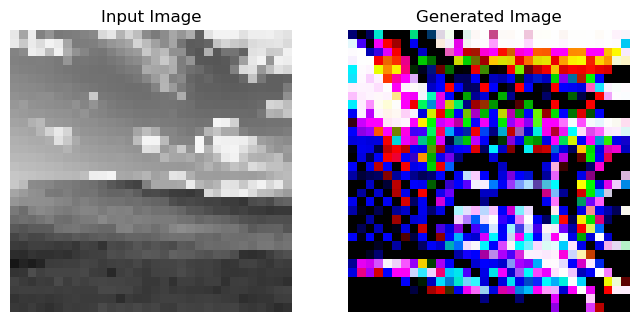

In [ ]:
import cv2
import matplotlib.pyplot as plt
# Load a sample input image
img_path = 'bliss.png'
input_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
input_image = cv2.resize(input_image, (32, 32))
input_image = input_image.astype('float32') / 255.0
input_image = np.expand_dims(input_image, axis=-1)
input_image = tf.stack([input_image[:, :, :]]*3, axis=-1)

# Generate an output image using the trained GAN model
noise = generate_noise(1, 100)
generated_image = generator.predict(noise)

# Display the input and output images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image[:, :, 0], cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(generated_image[0, :, :, :], cmap='gray')
plt.title('Generated Image')
plt.axis('off')
plt.show()


In [ ]:
# Save the generator model
generator.save('model2-local.h5')


In [ ]:
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Shuffle the data
    np.random.shuffle(x_train)

    # Loop over batches of data
    for step in range(steps_per_epoch):
        # Sample a batch of real images
        real_images = x_train[step * batch_size:(step + 1) * batch_size]

        # Generate a batch of fake images
        noise = generate_noise(batch_size, 100)
        fake_images = generator.predict(noise)

        # Train the discriminator on real and fake images
        discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
        discriminator_loss = 0.5 * (discriminator_loss_real + discriminator_loss_fake)

        # Train the generator to fool the discriminator
        noise = generate_noise(batch_size, 100)
        generator_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print the losses for this step
        print(f"Step {step+1}/{steps_per_epoch} - D loss: {discriminator_loss:.4f}, G loss: {generator_loss:.4f}")


In [ ]:
# Save the generator model
generator.save('generator_model.h5')